In [76]:
import numpy as np
import scipy

class RadiationFunctions:
    
    def __init__(self):
        
        self.planck_constant = 6.62607015e-34 #J/s
        self.boltzmann_constant = 1.3806452e-23 #J/K
        self.light_speed = 3e8 #m/s
        
    def check_errors(self, errors, messages): 
        '''
        Checks if there are any ValueErrors with the given inputs.
        
        Inputs
        -------
        errors: array
            Boolean array of all the possible input errors.
            
        messages: array 
            Array of strings that would be outputted given a specific error.
            
        Raises
        ------
        ValueError:
            If there are any True values in the errors array.
        '''
        
        #check if there are any errors
        if errors.any() == True:
            
            #find what the specific errors are
            issues = np.where(errors == True)[0]
            
            #initialize an error message
            error_message = ''
            
            #go through each error
            for issue in issues:
                
                #add to the error message for the given error
                error_message += 'The ' + messages[issue]
                if issue == issues[-1]:
                    break
                error_message += ' and '
                
            raise ValueError(error_message)
        
    def planck_function(self, wavelength, temperature):
        '''
        Calculate spectral radiance from Planck’s law.
        
        Inputs
        -------
        wavelength: float or array
            Wavelength in meters.
            
        temperature: float 
            Temperature in Kelvin.
            
        Outputs
        --------
        float or array:
            Spectral radiance in W.m-2.sr-1.um-1
        '''
        
        #check for input errors
        errors = np.asarray([temperature <= 0, wavelength <= 0])
        
        messages = np.asarray(['temperature variable should be greater than zero', 
                             'wavelength variable should be greater than zero'])
        
        self.check_errors(errors, messages)
        
        return 2*self.planck_constant*(self.light_speed**2)/(wavelength**5) * 1/(np.e**(self.planck_constant*self.light_speed/(wavelength*self.boltzmann_constant*temperature)) - 1)
        
    def planck_inv(self, wavelength, spectral_radiance):
        '''
        Calculate temperature from spectral radiance using Planck’s law.
        
        Inputs
        -------
        wavelength: float
            Wavelength in meters.
            
        spectral_radiance: float 
            Spectral radiance in W.m-2.sr-1.um-1.
            
        Outputs
        --------
        float or array:
            Temperature in Kelvin.
        '''
        
        #check for input errors
        errors = np.asarray([temperature <= 0, spectral_radiance <= 0])
        
        messages = np.asarray(['temperature variable should be greater than zero', 
                             'spectral_radiance variable should be greater than zero'])
        
        self.check_errors(errors, messages)
        
        return self.planck_constant*self.light_speed/(wavelength*self.boltzmann_constant*np.log(2*self.planck_constant*self.light_speed**2/(spectral_radiance*wavelength**5) + 1))
    
    def radiance(self, temperature, band_center, band_width):
        '''
        Calculate band-integrated radiance for a given temperature and rectangular bandpass.

        Integrates Planck function over a rectangular bandpass defined by its center wavelength
        and width. The bandpass is assumed to have unity transmission within its bounds and
        zero outside.
        
        Inputs
        -------
        temperature: float
            Temperature in Kelvin.
            
        band_center: float
            Center wavelength of bandpass in meters.
            
        band_width: float
            Width of bandpass in meters.
            
        Outputs
        --------
        float:
            Band integrated radiance in W.m-2.sr-1.um-1.
            
        Raises
        ------
        ValueError:
            If temperature <= 0, band_width <= 0, or band_center <= band_width/2.
        '''
        
        #check for input errors
        errors = np.asarray([temperature <= 0, band_width <= 0, band_center <= band_width/2])
        
        messages = np.asarray(['temperature variable should be greater than zero', 
                             'band_width variable should be greater than zero', 
                             'band_center variable should be larger than half of band_width'])

        self.check_errors(errors, messages)
        
        #create a planck function with variable wavelength given the input temperature
        planck_function = lambda wavelength: self.planck_function(wavelength, temperature)
        
        #integrate the planck function over all wavelengths
        radiance = scipy.integrate.quad(planck_function, band_center - band_width/2, band_center + band_width/2)[0]
        
        return radiance
    
    def calculate_NEDT(self, NER, temperature, band_center, band_width):
        ''' 
        Calculate the noise-equivalent differential temperature (NEDT)
        for given scene temperature and noise - equivalent radiance (NER).

        Uses numerical derivative of band-integrated radiance with respect
        to temperature to determine the temperature uncertainty corresponding
        to the NER .

        Inputs
        -------
        NER: float
            Noise-equivalent radiance in W .m -2. sr -1
            
        temperature: float
            Temperature in Kelvin.
            
        band_center: float
            Center wavelength of bandpass in meters.
            
        band_width: float
            Width of bandpass in meters.

        Output
        -------
        float:
            NEDT in Kelvins.

        Raises
        ------
        ValueError:
            If temperature <= 0, band_width <= 0, or band_center <= band_width/2.
        '''

        #check for input errors
        errors = np.asarray([temperature <= 0, band_width <= 0, band_center <= band_width/2])
        
        messages = np.asarray(['temperature variable should be greater than zero', 
                             'band_width variable should be greater than zero', 
                             'band_center variable should be larger than half of band_width'])
        
        self.check_errors(errors, messages)
        
        #find the band integrated radiance
        radiance = self.radiance(temperature, band_center, band_width)
        
        #initialize a lookup table for temperatures and radiances
        lookup_table = np.zeros((2, temperature))
        
        #go through a range of temperatures
        for idx, temp in enumerate(range(int(temperature/2), temperature + int(temperature/2))):
            
            #populate the lookup table
            lookup_table[0][idx] = temp
            lookup_table[1][idx] = self.planck_function(band_center, temp)
        
        #interpolate the lookup table to find the temperatures associated with R + dR and R
        #calculate the difference between the two temperatures to find NEDT
        NEDT = np.interp(radiance + NER, lookup_table[1], lookup_table[0]) - np.interp(radiance, lookup_table[1], lookup_table[0])
        
        return NEDT
    
    def calculate_exact_NEDT(self, NER, temperature, band_center, band_width):
        ''' 
        Calculate the noise-equivalent differential temperature (NEDT)
        for given scene temperature and noise - equivalent radiance (NER).

        Uses exact derivative of band-integrated radiance with respect
        to temperature to determine the temperature uncertainty corresponding
        to the NER.

        Inputs
        -------
        NER: float
            Noise-equivalent radiance in W .m -2. sr -1
            
        temperature: float
            Temperature in Kelvin.
            
        band_center: float
            Center wavelength of bandpass in meters.
            
        band_width: float
            Width of bandpass in meters.

        Output
        -------
        float:
            NEDT in Kelvins.

        Raises
        ------
        ValueError:
            If temperature <= 0, band_width <= 0, or band_center <= band_width/2.
        '''
        
        #initialize parameters associated with the planck function for cleaner calculations
        coeff = 2*self.planck_constant*self.light_speed**2
        exponent = self.planck_constant*self.light_speed/(self.boltzmann_constant*temperature)
        
        #create a wavelength dependent function for dT/dR
        dTdR = lambda lambd: ((2 * self.light_speed**3 * self.planck_constant**2 * np.e**((self.light_speed * self.planck_constant) / (lambd * self.boltzmann_constant * temperature)))/(lambd**6 * self.boltzmann_constant * temperature**2 * (np.e**((self.light_speed * self.planck_constant) / (lambd * self.boltzmann_constant * temperature)) - 1)**2))**(-1)
        
        #integrate dT/dR over all wavelengths and multiply by NER to find NEDT
        NEDT = NER*scipy.integrate.quad(dTdR, band_center - band_width/2, band_center + band_width/2)[0]
        
        return NEDT

## Basic Validation and Bandpass Effects

### Plotting the Plank Functions of the Sun, Earth, and Europa

/var/folders/8p/38pm8zfs7t7dvr2wfs_pks7c0000gn/T/ipykernel_80954/4282196601.py:44: RuntimeWarning: overflow encountered in power
  return 2*self.planck_constant*(self.light_speed**2)/(wavelength**5) * 1/(np.e**(self.planck_constant*self.light_speed/(wavelength*self.boltzmann_constant*temperature)) - 1)


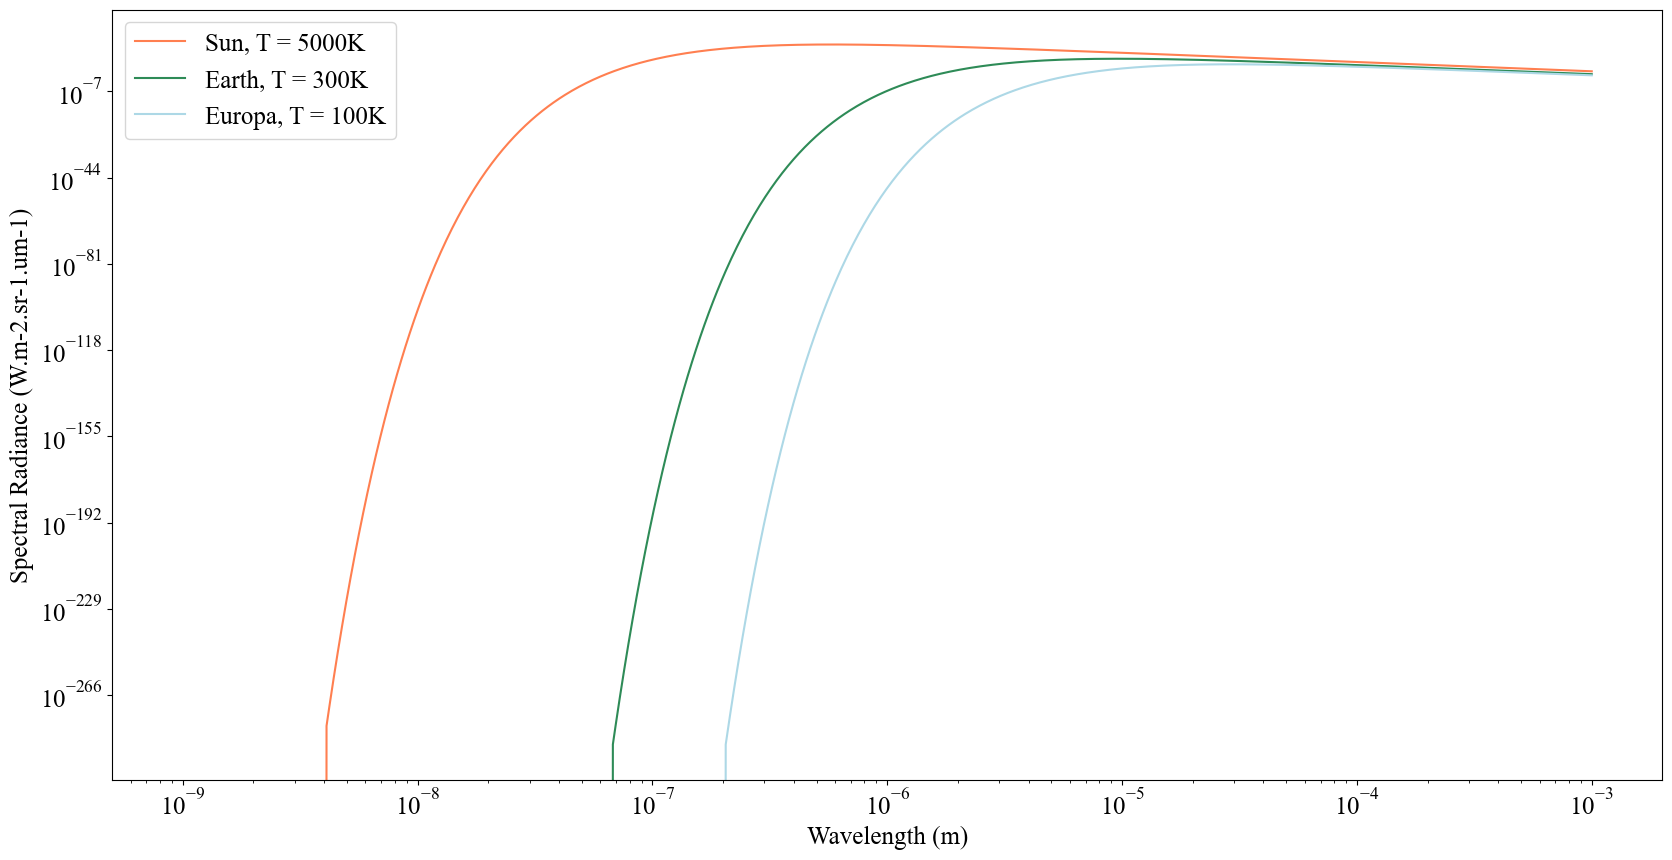

In [98]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "18"

wavelengths = np.logspace(-3, -9, 1000)

rd = RadiationFunctions()

plt.figure(figsize = (20, 10))
plt.loglog(wavelengths, rd.planck_function(wavelengths, 5000), label = 'Sun, T = 5000K', color = 'coral')
plt.loglog(wavelengths, rd.planck_function(wavelengths, 300), label = 'Earth, T = 300K', color = 'seagreen')
plt.loglog(wavelengths, rd.planck_function(wavelengths, 100), label = 'Europa, T = 100K', color = 'lightblue')
plt.xlabel('Wavelength (m)')
plt.ylabel('Spectral Radiance (W.m-2.sr-1.um-1)')
plt.legend()

### Testing that the inverse Planck Function recovers input temperatures

In [104]:
errors = []
wavelength = 1e-6

for temperatures in range(1, 5000):
    for wavelengths in np.logspace(-3, -9, 1000):
        
        if rd.planck_inv(wavelength, rd.planck_function(wavelength, temperature)) != temperature:
            print("Inverse Planck Function couldn't recover input temperatures")

### Integrated radiance as a function of temperature for different bandwidths

/var/folders/8p/38pm8zfs7t7dvr2wfs_pks7c0000gn/T/ipykernel_80954/4282196601.py:44: RuntimeWarning: overflow encountered in scalar power
  return 2*self.planck_constant*(self.light_speed**2)/(wavelength**5) * 1/(np.e**(self.planck_constant*self.light_speed/(wavelength*self.boltzmann_constant*temperature)) - 1)


Text(0, 0.5, 'Band Integrated Radiance (W.m-2.sr-1.um-1)')

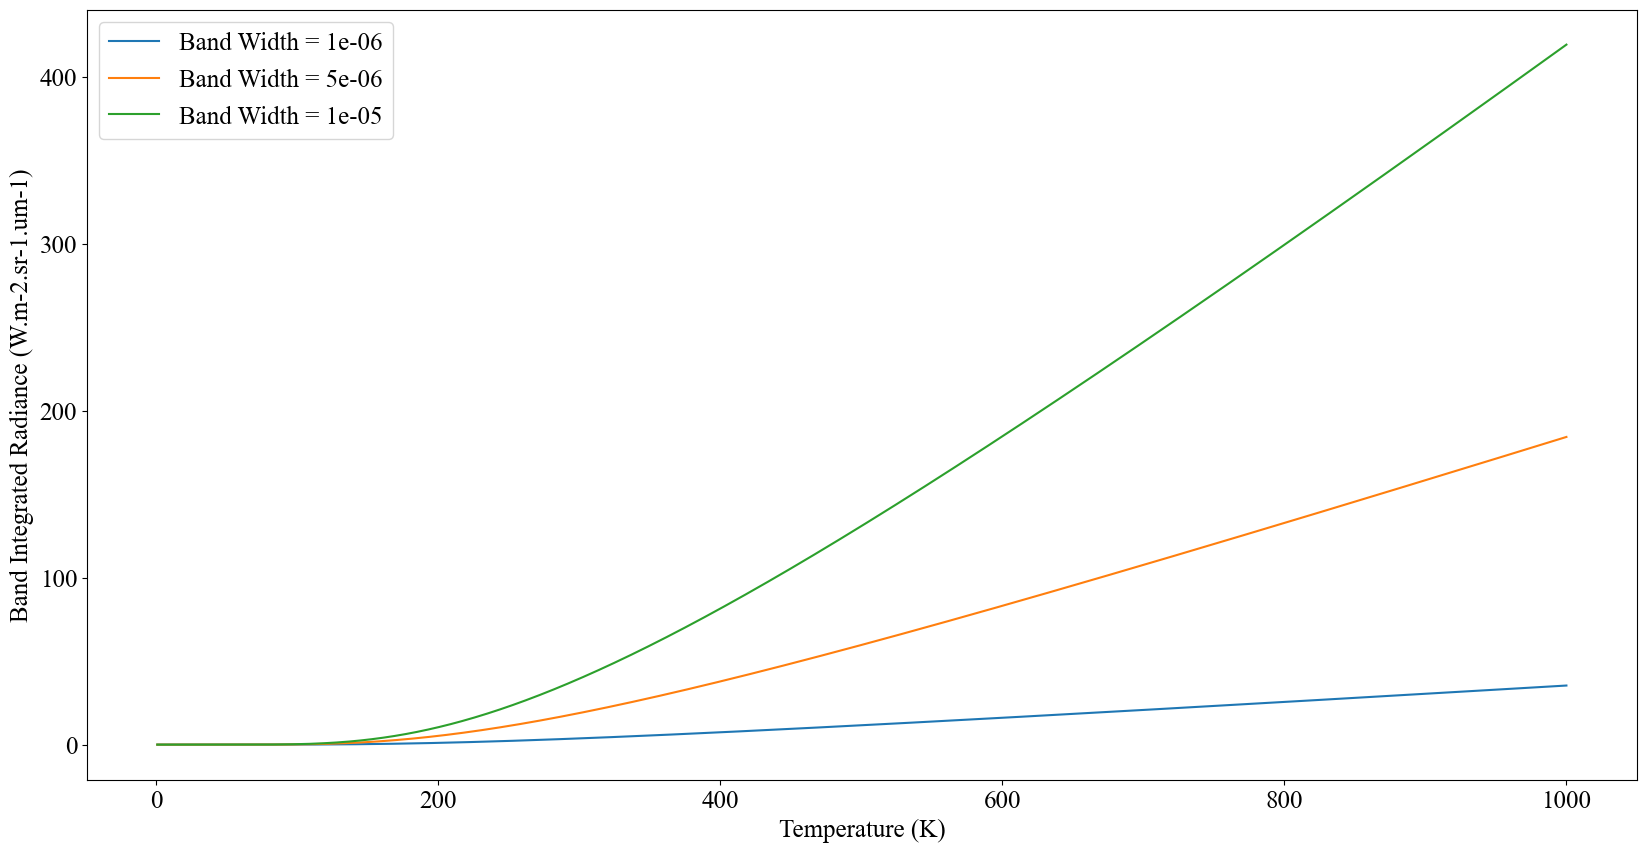

In [109]:
band_widths = [1e-6, 5e-6, 10e-6]
band_center = 20e-6
temperatures = np.linspace(1, 1000, 1000)

plt.figure(figsize = (20, 10))

for band_width in band_widths:
    
    radiance = []
    
    for temperature in temperatures:
        radiance.append(rd.radiance(temperature, band_center, band_width))
    
    plt.plot(temperatures, radiance, label = 'Band Width = {}'.format(band_width))

plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('Band Integrated Radiance (W.m-2.sr-1.um-1)')

### Real World Applications

In [114]:
radiance1 = rd.radiance(110, 11.5e-6, 7e-6)
brightness_temperature1 = rd.planck_inv(11.5e-6, radiance)

radiance2 = rd.radiance(110, 21e-6, 14e-6)
brightness_temperature2 = rd.planck_inv(21e-6, radiance)

radiance3 = rd.radiance(110, 54e-6, 52e-6)
brightness_temperature3 = rd.planck_inv(54e-6, radiance)

print("Europa has an average surface temperature of 110K and the E-THEMIS instrument has a 7-14 microns band.")
print("So, its measured radiance would be {} W.m-2.sr-1.um-1 and therefore, its measured brightness temperature would be {} K.".format(radiance1, brightness_temperature1))
print("However, with the 14-28 microns band, we would measure a radiance of {} W.m-2.sr-1.um-1 and a temperature of {} K.".format(radiance2, brightness_temperature2))
print("Lastly, with the 28-80 microns band, we would measure a radiance of {} W.m-2.sr-1.um-1 and a temperature of {} K.".format(radiance3, brightness_temperature3))

Europa has an average surface temperature of 110K and the E-THEMIS instrument has a 7-14 microns band.
So, its measured radiance would be 0.06257874286590687 W.m-2.sr-1.um-1 and therefore, its measured brightness temperature would be 54.500258681694945 K
However, with the 14-28 microns band, we would measure a radiance of 0.7270255492928613 W.m-2.sr-1.um-1 and a temperature of 34.34716912332496 K
Lastly, with the 28-80 microns band, we would measure a radiance of 1.565267531283775 W.m-2.sr-1.um-1 and a temperature of 17.496462781853495 K
